# Data pre-processing 

In this notebook, we start from the data downloaded from https://openflights.org/data.html and we create interesting DataFrames and an adjacency matrix.

## Extract Data

### Extraction

In [1]:
import pandas as pd

In [2]:
features = pd.read_csv("data/routes.dat", names = ["airline",
                                              "airline_id",
                                              "source_airport",
                                              "source_airport_id",
                                              "destination_airport",
                                              "destination_airport_id",
                                              "codeshare",
                                              "stops",
                                              "equipment"])
features.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [3]:
airports = pd.read_csv("data/airports.dat", names = ["airport_id", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"])
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


### Create nodes and edges

In [4]:
import numpy as np

In [5]:
source_airports = features[["source_airport_id", "source_airport"]]
source_airports.columns = ["airport_id", "airport"]

destination_airports =  features[["destination_airport_id", "destination_airport"]]
destination_airports.columns = ["airport_id", "airport"]

nodes = pd.concat([source_airports,destination_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace='\\N', value=np.NaN, inplace=True)
nodes.dropna(axis=0, inplace=True)
nodes["airport_id"] = nodes["airport_id"].apply(int)   #Convert IDs to int to allow merge

nodes.head()

,airport_id,airport
0,2965,AER
1,2966,ASF
3,2968,CEK
5,4029,DME
9,6156,EGO


In [6]:
edges = features[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace='\\N', value=np.NaN)
edges = edges.dropna(axis=0)
edges["source_airport_id"] = edges["source_airport_id"].apply(int)   #Convert IDs to int to allow merge
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)   #Convert IDs to int to allow merge

edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


### Add longitude and latitude to nodes

In [7]:
nodes = nodes.merge(airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]], how='left', on='airport_id')
nodes["TzDatabase"] = nodes["TzDatabase"].apply(lambda x: str(x).split("/")[0])
nodes.columns = ["airport_id", "airport", "Latitude", "Longitude", "Continent"]
nodes.set_index("airport_id", inplace=True)

# Drop nodes for which we don't have coordonates
nodes.dropna(inplace=True)

nodes.head()

,airport,Latitude,Longitude,Continent
airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


### Convert airport id to node id

In [8]:
# Conversion table from airport_id to node index.
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx.reset_index(level = 0, inplace = True)
airport_id2idx.columns = ["node_idx", "airport_id"]
airport_id2idx.set_index("airport_id", inplace = True)

In [9]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "source_airport_id",
                 right_index = True,
                 sort = False)

In [10]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "destination_airport_id",
                 right_index = True,
                 sort = False,
                 suffixes = ("_source", "_destination"))

edges = edges.drop_duplicates()  # Avoid multilinks

In [11]:
edges.head()

,source_airport_id,destination_airport_id,node_idx_source,node_idx_destination
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


## Create adjacency matrices

### Create non-weighted adjacency matrix

In [12]:
n_nodes = nodes.shape[0]
n_nodes

3186

In [13]:
# Non-weighted adjacency
adjacency = np.zeros((n_nodes, n_nodes))

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        adjacency[i, j] = 1

# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if adjacency[i][j] != 0:
            adjacency[j][i] = adjacency[i][j]

### Create heat kernel weighted adjacency

In [14]:
from geopy import distance

In [15]:
sigma = 1200 #1751 is the mean distance, sigma is tunable and changes the results. Optimal : 1200
weighted_matrix_inv = np.zeros((n_nodes, n_nodes))

dists = []

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
        dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])
        dist = distance.geodesic(source_coords, dest_coords).km
        dists.append(dist)
        weighted_matrix_inv[i, j] = np.exp(-dist/sigma)
        
mean_dist = sum(dists)/len(dists)

# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix_inv[i][j] != 0:
            weighted_matrix_inv[j][i] = weighted_matrix_inv[i][j]

## Compute biggest cluster indices

Here we chose not not to use pre-implemented functions because we want to access the indices of the biggest cluster, and not only its values.

In [16]:
#Breadth first search algorithm

def bfs(adjacency, start_node):
    """
    The BFS compute the shortest path for the hop-distance
        
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    start_node: int
        Node from where all distances are computed.
    
    Returns
    -------
    list of numpy arrays
        A list of distances from start_node.
    
    """
    distance_from_start_node = np.Inf * np.ones(adjacency.shape[0])   # Unlabelled are set to inf
    distance_from_start_node[start_node] = 0
    queue = [(start_node, 0)]
    
    while queue:
        current_node = queue.pop(0)
        link_nodes = link_nodes_unlabelled(adjacency, current_node, distance_from_start_node)
        for node in link_nodes:
            distance_from_start_node[node[0]] = node[1]
        queue += link_nodes
    
    return distance_from_start_node


def link_nodes_unlabelled(adjacency, current_node, distance_from_start_node):
    """
    Function that returns new nodes linked to current_node and their hop-distance to origin.
        
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    current_node: int
        Node where we look at the connections.
    distance_from_start_node: numpy array
        Array of distances.
    
    Returns
    -------
    list of numpy arrays
        A list of new nodes linked to current_node.
    
    """
    link_nodes = []
    for idx in range(adjacency.shape[0]):
        if adjacency[current_node[0],idx] > 0 and distance_from_start_node[idx] == np.Inf:
            link_nodes.append((idx, current_node[1]+1))     # Add unlabelled nodes linked to the current node with label +1
    return link_nodes

In [17]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    components = []
    n_nodes = adjacency.shape[0]
    n = 1
    unseen_nodes = [i for i in range(n_nodes)]
    a=[]
    while unseen_nodes:
        connected_components = []
        current_node = np.random.choice(unseen_nodes)   # Choose a random unseen node
        distance_from_start_node = bfs(adjacency, current_node)  # Compute BFS from this node
        
        for idx, dist in enumerate(distance_from_start_node):
            if dist != np.Inf:     # The connected nodes (from a source) are the labelled nodes !
                connected_components.append(idx)
        
        unseen_nodes = [e for e in unseen_nodes if e not in connected_components] # Update unseen nodes
        a.append(connected_components)
    return a

In [18]:
bg_indices = find_components(weighted_matrix_inv)[0]

### Extract adjacency matrices of the biggest cluster

In [19]:
bg_adjacency = adjacency[:,bg_indices][bg_indices,:]

In [20]:
bg_heat = weighted_matrix_inv[:,bg_indices][bg_indices,:]

In [21]:
n_nodes_bg = len(bg_indices)

### Verification of basic properties

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
#Check the connected components of bg_heat
len(sorted(nx.connected_component_subgraphs(nx.from_numpy_matrix(bg_heat)), key = len, reverse=True))

1

In [24]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

check_symmetric(bg_heat)

True

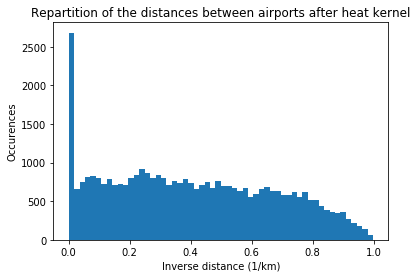

In [25]:
# plot distance repartition
values = []

for i in range(n_nodes_bg):
    for j in range(n_nodes_bg):
        if bg_heat[i][j] != 0:
            values.append(bg_heat[i][j])
            
plt.hist(values, bins = int(np.sqrt(n_nodes_bg)))
plt.xlabel("Inverse distance (1/km)")
plt.ylabel("Occurences")
plt.title("Repartition of the distances between airports after heat kernel")
plt.show()

## Labelling

In [26]:
#ground truth
dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = nodes.Continent
labels = np.array(labels.replace(dic).tolist())

In [27]:
#https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
dic_color = {0: '#e6194b',
             1: '#3cb44b',
             2: '#ffe119',
             3: '#4363d8',
             4: '#f58231',
             5: '#911eb4',
             6: '#46f0f0',
             7: '#f032e6',
             8: '#bcf60c',
             9: '#fabebe',
             10: '#008080',
             11: '#e6beff',
             12: '#9a6324',
             13: '#000000',
             14: '#800000',
             15: '#aaffc3',
             16: '#808000',
             17: '#ffd8b1',
             18: '#000075',
             19: '#808080'
}

In [28]:
#Labels for bg_heat

labels_bg = labels[bg_indices]
     
ground_truth = [dic_color[labels_bg[i]-1] for i in range(len(labels_bg))]

In [29]:
"""Corrections"""

#nan are changed to the color of the nearest neighbour
gt_without_nan = ground_truth.copy()
labels_without_nan = labels_bg.copy()
for i in range(len(ground_truth)):
    if gt_without_nan[i] == '#008080': #nan color
        weight = 0
        index_min = 0
        for j in range(len(ground_truth)-1):
            if (gt_without_nan[j]!='#008080') and bg_heat[i][j]>weight:
                weight = bg_heat[i][j]
                index_min = j
        gt_without_nan[i] = gt_without_nan[index_min]
        labels_without_nan[i] = labels_without_nan[index_min]

#Small correction, Pevek (Asia) in Russia is only connected to Moscow (Europe)
gt_without_nan[2774] = '#ffe119'
labels_without_nan[2274] = 2